<a href="https://colab.research.google.com/github/aebongbing/ESAA/blob/main/20230926_%EB%AF%B8%EB%8B%88_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%B4%88%EC%95%88(%EC%99%84%EC%84%B1%EB%B3%B8)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#matplotlib 한글 깨짐방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') #matplotlib 한글 깨짐 방지

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
train=pd.read_csv("/content/movies_train.csv")
test=pd.read_csv("/content/movies_test.csv")
submission=pd.read_csv("/content/submission.csv")

In [4]:
#결측값을 모두 0으로 채우기
train['dir_prev_bfnum'].fillna(0, inplace=True)
test['dir_prev_bfnum'].fillna(0, inplace=True)

In [5]:
#release_time을 datetime형식으로 변환
train['release_time']=pd.to_datetime(train['release_time'])
test['release_time']=pd.to_datetime(test['release_time'])

#가설 검증

가설1) 스텝수가 많은 영화일수록 비용을 줄이기 위해 주연배우수가 적을 것이다


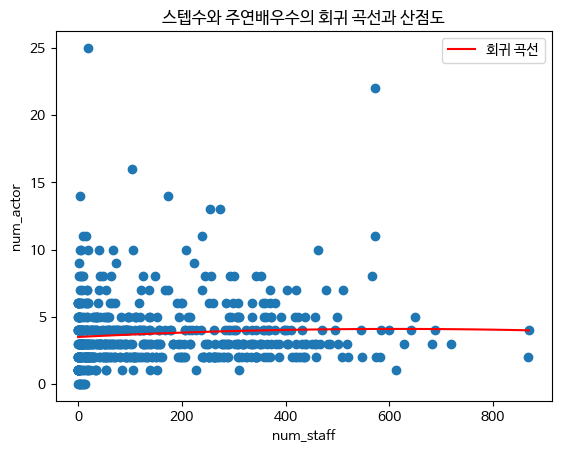

In [6]:
# 샘플 데이터 생성
x = np.array(train['num_staff'], dtype=float)  # 'num_staff' 열을 숫자로 변환
y = np.array(train['num_actor'], dtype=float)  # 'num_actor' 열을 숫자로 변환

# 다항 회귀 모델 생성 (예시로 2차 다항식 사용)
coefficients = np.polyfit(x, y, 2)  # 2차 다항식으로 회귀 모델 생성
poly = np.poly1d(coefficients)

# x 범위 설정
x_range = np.linspace(min(x), max(x), max(train['num_actor']))

# 다항 회귀 곡선 계산
y_pred = poly(x_range)

# 산점도와 회귀 곡선 그리기
plt.scatter(x, y)
plt.plot(x_range, y_pred, color='red', label='회귀 곡선')
plt.xlabel('num_staff')
plt.ylabel('num_actor')
plt.title('스텝수와 주연배우수의 회귀 곡선과 산점도')
plt.legend()
plt.show()

산점도와 회귀 그래프를 분석한 결과, 두 변수간의 유의미한 상관관계가 보이지 않는다. 따라서 가설1은 틀린 것으로 간주한다.

가설2) 대중적으로 유명한 감독일수록 몸값이 높은 탑스타를 주연으로 쓸 것이기 떄문에 주연배우수가 적을 것이다


<Figure size 1200x600 with 0 Axes>

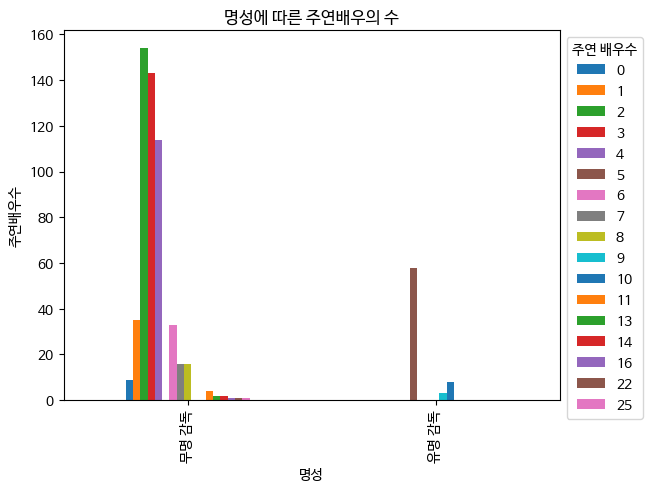

In [13]:
# 'dir_prev_bfnum' 열의 데이터 타입을 float로 변환
train['dir_prev_bfnum'] = train['dir_prev_bfnum'].astype(float)

# 각 감독의 'dir_prev_bfnum'의 평균을 계산
mean_dir_prev_bfnum_per_director = train.groupby('director')['dir_prev_bfnum'].mean()

# 모든 감독의 평균 'dir_prev_bfnum' 값을 다시 평균
overall_mean_dir_prev_bfnum = mean_dir_prev_bfnum_per_director.mean()

# 유명 감독 무명 감독 정의
def dir_famous(director):
    if mean_dir_prev_bfnum_per_director[director] <= overall_mean_dir_prev_bfnum:
        return '무명 감독'
    else:
        return '유명 감독'

# 주연 배우수를 기반으로 명성 열 추가
train['fame'] = train['num_actor'].apply(dir_famous)

# 명성에 따은 주연배우의 수
fame_actor_counts = train.groupby(['fame','num_actor']).size().unstack().fillna(0)

# 시각화
plt.figure(figsize=(12, 6))
fame_actor_counts.plot(kind='bar')
plt.title('명성에 따른 주연배우의 수')
plt.xlabel('명성')
plt.ylabel('주연배우수')
plt.legend(title='주연 배우수', bbox_to_anchor=(1, 1))
plt.show()


무명감독들이 유명감독들보다 훨씬 많은 수의 주연 배우들을 쓴다는 것을 알 수 있으므로 가설2 는 참이다.

가설3) 유명 감독이 무명 감독보다 이전에 만든 영화의 수가 더 많고, 해당 영화의 관객수가 많을 것이다

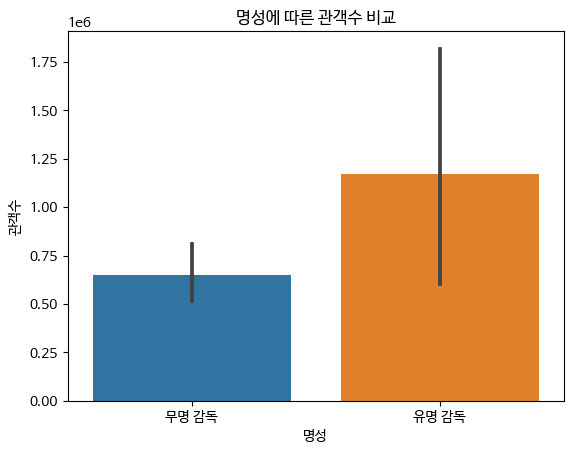

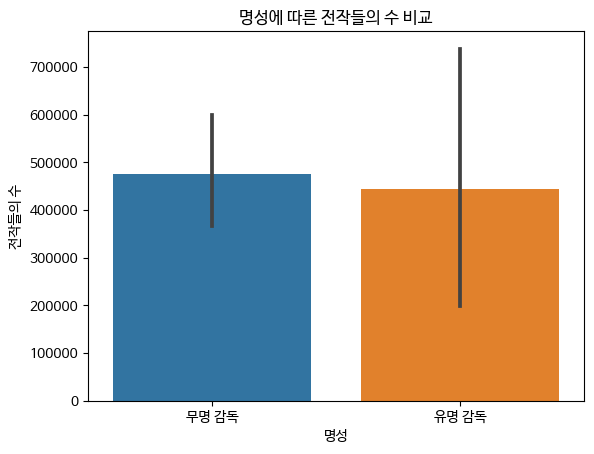

In [12]:
#막대 그래프 그리기
sns.barplot(x='fame', y='box_off_num', data=train)
plt.xlabel('명성')
plt.ylabel('관객수')
plt.title('명성에 따른 관객수 비교')
plt.show()

sns.barplot(x='fame', y='dir_prev_bfnum', data=train)
plt.xlabel('명성')
plt.ylabel('전작들의 수')
plt.title('명성에 따른 전작들의 수 비교')
plt.show()

유명 감독의 관객수가 무명 감독에 비해 더 높은 것은 맞으나 유명 감독과 무명 감독 간의 전작들의 수는 유명 감독이 더 높은 이상치를 지니고 있고 그 외에는 별다른 차이가 없다는 것을 알 수 있다. 따라서 가설3은 관객수 관련으로는 참이나 전작들의 수에 관해서는 맞다고 할 수 없다.

가설4) 유명 감독은 무명 감독에 비해 더 많은 비용을 투자받아 영화의 평균 상영시간이 더 길 것이다

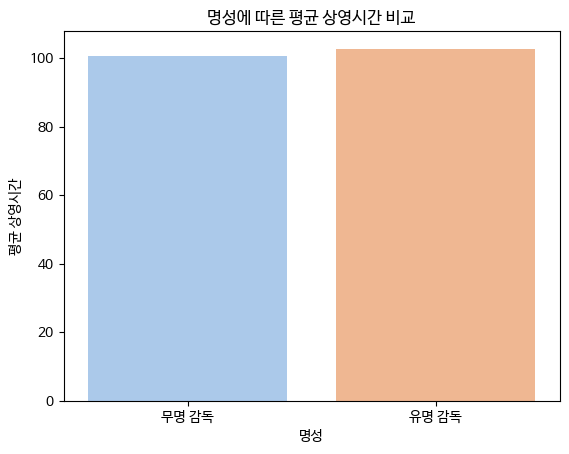

In [22]:
# 'time' 열의 데이터 타입을 float로 변환
train['time'] = train['time'].astype(float)

# 명성에 따른 평균 상영시간 구하기
train['mean_time'] = train.groupby('fame')['time'].transform('mean')

# 막대 그래프 그리기
sns.barplot(x='fame', y='mean_time', data=train, palette='pastel')
plt.xlabel('명성')
plt.ylabel('평균 상영시간')
plt.title('명성에 따른 평균 상영시간 비교')
plt.show()

유명 감독과 무명 감독간의 평균 상영시간의 차이가 거의 없으므로 해당 가설은 기각된다.